# Imports and Configuration

Importing all needed packages and files

In [17]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

In [24]:
import datetime
import warnings


import sys
sys.path.append('conditional_gan/')

In [19]:
import torch.utils.data
import os.path
import random
import torchvision.transforms as transforms
from numpy import inf
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib.pyplot import figure
import time
from scipy.signal import convolve


In [20]:
import netCDF4 as nc4

Configuration of packages

In [46]:
warnings.filterwarnings('ignore')
plt.rcParams['axes.facecolor'] = 'white'

font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 14}
plt.rc('font', **font)

plt.style.use('ggplot')


# Loading Data and Models

In [22]:
mask = np.load("OceanMask.npy")
mask = resize(mask.astype(np.float), (64,64))
mask[mask == 1] = np.nan
mask = mask + 1

In [26]:
from networks import define_G


model_path = "conditional_gan/SavedModels/latest"
model = define_G(6, 1, 32, 'instance', 'resnet', False, [0])
model.load_state_dict(torch.load(model_path)['netG_A_B'])
model.eval()

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): 

In [27]:
test_data_input = dict(np.load('datasets/livneh/testA.npz'))
test_data_ouput = dict(np.load('datasets/livneh/testB.npz'))

data_A = test_data_input['data']
data_B = test_data_ouput['data']

# Helper Functions

Helper functions for data processing and analysis

In [120]:
def take_two_weeks(input_data, start_date):
    """Takes input data array (shape as data_A or data_B), and returns a 2-week (14 day) long slice of it starting at start_date. Used for seasonal histograms."""
    return input_data[start_date:start_date + 14, :, :, :]

def arr_to_input(arr):
    """Takes an input numpy array, removes all nan, normalize, resize, and reshapes for to turn into valid input.A"""
    arr = np.nan_to_num(arr)
    if arr.ndim == 3:
        arr = np.expand_dims(arr, axis=2)
    means = np.nanmean(arr, axis=(0,1,2))
    # scale and shift to [-1,1]
    arr = -1 + 2 * (arr - arr.min((1,2))[:, np.newaxis,np.newaxis]) / (arr.max((1,2))[:, np.newaxis,np.newaxis] - arr.min((1,2))[:, np.newaxis,np.newaxis])
    arr[np.isnan(arr)] = -1; arr[arr == inf] = -1; arr[arr == -inf] = -1
    if 64 is not None:
        new_arr = []
        #print "Resizing data to %d" % 64
        for x in arr:
            new_arr.append(resize(x, (64,64)))
        arr = np.stack(new_arr)
    # convert data from b,0,1,c to b,c,0,1
    arr = np.transpose(arr, (0,3,1,2))
    
    return arr.astype('float32')

def give_data_seq(inputA, inputB, start_date):
    """Returns real and generated data corresponding to two week period starting at start_date"""
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    return fake_B, real_B

def im_corr(im1, im2, circcorr = False):
    """Returns the padded 2d cross correlation of images"""
    corrmat = np.zeros(im1.shape) 
    if circcorr:
        shiftmat = np.tile(im2, (2,2))
    else:
        top = np.concatenate((np.zeros(im2.shape), np.zeros(im2.shape)), axis=1)
        bottom = np.concatenate((im2, np.zeros(im2.shape)), axis = 1)
        shiftmat = np.concatenate((top, bottom))
    corrmat = sp.signal.convolve(im1, shiftmat, 'same')
    return (corrmat - np.min(corrmat))/(np.max(corrmat) - np.min(corrmat))

def im_circcorr(im1, im2):
    """Returns the circular 2d cross correlation of images"""
    return im_corr(im1, im2, True)

def take_radial_slice_mean(image, radius, distances):
    """Takes radial average of an image, meant for 2d fourier space"""
    return image[(distances >= radius-.5) & (distances  < radius+.5)].mean()

def power_spectral_density(im):
    """Returns the power spectral density of an image: 2 * 10 * log(abs(fft(autocorrelation(image))))"""
    temp = (im - np.mean(im))/np.var(im)
    psd = np.log10(abs(np.fft.fftshift(np.fft.fft2(im_corr(temp, temp)))))*20
    x,y = np.meshgrid(np.arange(im.shape[1]),np.arange(im.shape[1]))
    center = (im.shape[0]//2, im.shape[1]//2)
    x -= center[0]
    y -= center[1]
    R = np.sqrt(x**2 + y**2)
    r  = np.linspace(0,int(np.max(R)),num=int(np.max(R))*4)
    means = []
    # plot it
    for dist in r:
        #print(dist)
        means.append(take_radial_slice_mean(psd, dist, R))
    return means

def energy_spectral_density(im):
    #print(im.shape)
    temp = (im - np.mean(im))/np.var(im)
    psd = np.log10(abs(np.fft.fftshift(np.fft.fft2(temp))))*20
    x,y = np.meshgrid(np.arange(im.shape[1]),np.arange(im.shape[1]))
    center = (im.shape[0]//2, im.shape[1]//2)
    x -= center[0]
    y -= center[1]
    R = np.sqrt(x**2 + y**2)
    r  = np.linspace(0,int(np.max(R)),num=int(np.max(R))*4)
    means = []
    # plot it
    for dist in r:
        #print(dist)
        means.append(take_radial_slice_mean(psd, dist, R))
    return means

def take_n_samples_random(data, n):
    """Takes n random slices of data"""
    image_indices = np.random.choice(804, n)
    return data[image_indices, :,:, :]

def give_data_random(inputA, inputB, num_days):
    """Similar to give_data_seq, but with random slices"""
    fake_B = model(torch.from_numpy(arr_to_input(take_n_samples_random(inputA, num_days))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_n_samples_random(inputB, num_days)))
    return fake_B, real_B

def compute_power_spectras(im_list, power=True):
    """Takes array of images and returns either power or energy spectral density"""
    radial_means_list = []
    for index in range(0, im_list.shape[0]):
        if index % 100 == 0: 
            print(index)
        if power:
            radial_means_list.append(power_spectral_density(im_list[index, 0, :, :].detach().numpy()))
        else:
            radial_means_list.append(energy_spectral_density(im_list[index, 0, :, :].detach().numpy()))
    return np.array(radial_means_list)

def np_hist_to_cv(np_histogram_output):
    """Turns numpy histogram to opencv"""
    counts, bin_edges = np_histogram_output
    return counts.ravel().astype('float32')

def log_metrics_np_hist(np_hist_real, np_hist_fake):
    """Takes numpy histograms and returns metrics computed on them."""
    OPENCV_METHODS = (("Correlation", cv2.HISTCMP_CORREL), ("Chi-Squared", cv2.HISTCMP_CHISQR), ("Intersection", cv2.HISTCMP_INTERSECT), ("Hellinger", cv2.HISTCMP_BHATTACHARYYA))
    cv_hist_real = np_hist_to_cv(np_hist_real)
    cv_hist_fake = np_hist_to_cv(np_hist_fake)
    results = {}
    for option in OPENCV_METHODS:
        temp_name = name + " " + option[0]
        results[temp_name] = cv2.compareHist(cv_hist_real, cv_hist_fake, option[1])


        
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)
    
def numpy_histograms(start_date, inputA, inputB, zero_mask, num_bins, to_plot = True):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    
    
    mask = np.ravel(np.tile(zero_mask, (real_B.shape[0], 1, 1, 1)))
    
    real_im = np.ravel(real_B.detach().numpy())*(mask/mask)
    fake_im = np.ravel(fake_B.detach().numpy())*(mask/mask)

    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    print(sp.stats.gaussian_kde(real_im))
    
    KS_stat, p_val = sp.stats.kstest(sp.stats.gaussian_kde(real_im), sp.stats.gaussian_kde(fake_im))
    
    #print(np.mean(real_im))

    
    
    #
    
    #got everything setup, now make bins and counts
    
    range_min = min(np.min(real_im), np.min(fake_im))
    range_max = max(np.max(real_im), np.max(fake_im))
    
    real_hist_data = np.histogram(real_im, num_bins, (range_min, range_max))
    fake_hist_data = np.histogram(fake_im, num_bins, (range_min, range_max))
    
    if to_plot:
        fix, ax = plt.subplots(figsize=(10, 10))
        ax.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
        ax.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
        ax.legend(loc='upper right')
        title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
        ax.set_title(title)
        ax.set_yscale('log')
        ax.set_xlabel('Normalized Pixel Values')
        ax.set_ylabel('Log Counts')


    
    return real_hist_data, fake_hist_data, KS_stat, p_val

def take_n_samples_random_both(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]



def nov_aug_apr_hist(inputA, inputB, mask):
    starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
    

    
    
    f = plt.figure(figsize=(30,10))
    f.patch.set_facecolor('white')

    gs = gridspec.GridSpec(1, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    
    
    #ax10 = plt.subplot(gs[5, 0:3])
    
#     ax8 = plt.subplot(gs[2, 2])
    
    
    start_date = 300
    real_hist_data, fake_hist_data, KS_stat, p_val =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    real_hist_norm, fake_hist_norm = (real_hist_data[0])/np.sum(real_hist_data[0]), fake_hist_data[0]/np.sum(fake_hist_data[0])
    
    print(KS_stat, p_val)

    
    ax1.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Physics Model SWE')
    ax1.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'cGAN SWE')
    ax1.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax1.set_title("Histogram of August Data with KS stat: " + str(np.round(KS_stat, decimals = 3)))
    ax1.set_yscale('log')
    ax1.set_xlabel('Normalized Pixel Values')
    ax1.set_ylabel('Log Counts')
    
     
    start_date = 400
    real_hist_data, fake_hist_data, KS_stat, p_val =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    real_hist_norm, fake_hist_norm = (real_hist_data[0])/np.sum(real_hist_data[0]), fake_hist_data[0]/np.sum(fake_hist_data[0])    

    print(KS_stat, p_val)
    ax2.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Physics Model SWE')
    ax2.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'cGAN SWE')
    ax2.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax2.set_title("Histogram of November Data with KS stat: " + str(np.round(KS_stat, decimals = 3)))
    ax2.set_yscale('log')
    ax2.set_xlabel('Normalized Pixel Values')
    
   
    start_date = 530
    real_hist_data, fake_hist_data, KS_stat, p_val =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    real_hist_norm, fake_hist_norm = (real_hist_data[0])/np.sum(real_hist_data[0]), fake_hist_data[0]/np.sum(fake_hist_data[0])
    print(KS_stat, p_val)

    ax3.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label ='Physics Model SWE')
    ax3.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'cGAN SWE')
    ax3.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax3.set_title("Histogram of April Data with KS stat: " + str(np.round(KS_stat, decimals = 3)))
    ax3.set_yscale('log')
    ax3.set_xlabel('Normalized Pixel Values')

Helper functions for plotting

In [34]:
def plot_spectra(radial_means_real, radial_means_fake, log):
    f = plt.figure(figsize=(30,20))
    f.patch.set_facecolor('white')
    
    
    psd_means_real = np.mean(radial_means_real, axis = 0)
    psd_stds_real = np.var(radial_means_real, axis = 0)**(0.5)
    
    psd_means_fake = np.mean(radial_means_fake, axis = 0)
    psd_stds_fake = np.var(radial_means_fake, axis = 0)**(0.5)
    
    
    x = np.linspace(0, 45.254833995939045, 180)
    y_real = psd_means_real
    error = 1.96 * psd_stds_real
    if log:
        plt.semilogx(x, y_real, 'k', color='#CC4F1B', label = 'Real')
    else:
        plt.plot(x, y_real, 'k', color='#CC4F1B', label = 'Real')
    plt.fill_between(x, y_real-error, y_real+error, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

    y_fake = psd_means_fake   
    error = 1.96 * psd_stds_fake
    if log:
        plt.semilogx(x, y_fake, 'k', color='#1B2ACC', label = 'Generated')
    else:
        plt.plot(x, y_fake, 'k', color='#1B2ACC', label = 'Generated')
    plt.fill_between(x, y_fake-error, y_fake+error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=4, linestyle='dashdot', antialiased=True)

    plt.legend()
    
    plt.title("Radial Power Spectral Density of SWE Maps")
    plt.xlabel("Spatial Frequency")
    plt.ylabel("Power Spectrum")

    return

# Data Preprocessing

In [37]:
fake, real = give_data_random(data_A, data_B, 200)


radial_means_real = []
radial_means_fake = []
radial_means_real = compute_power_spectras(real, True)
radial_means_fake = compute_power_spectras(fake, True )

psd_means_real = np.mean(radial_means_real, axis = 0)
psd_stds_real = np.var(radial_means_real, axis = 0)**(0.5)

psd_means_fake = np.mean(radial_means_fake, axis = 0)
psd_stds_fake = np.var(radial_means_fake, axis = 0)**(0.5)

0
100
0
100


<function scipy.stats.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='approx')>

# Examples of Plots

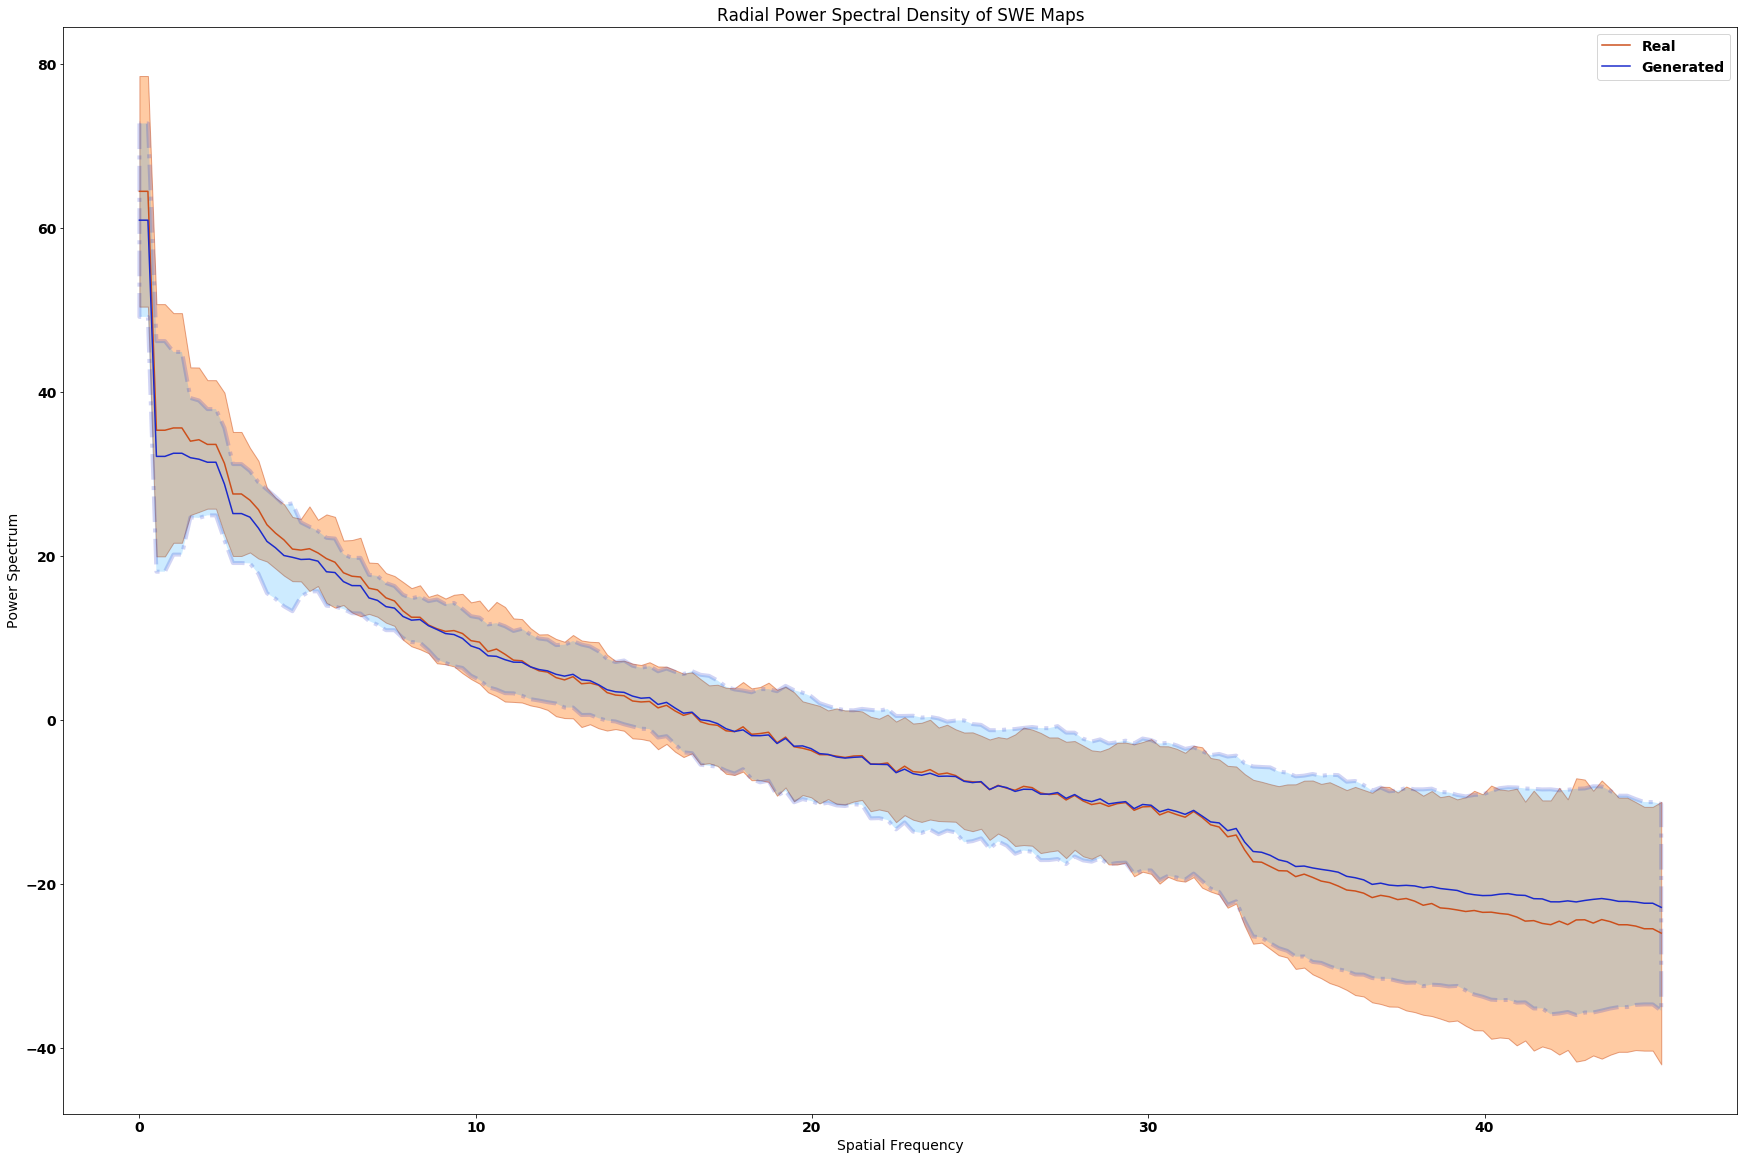

In [42]:
plot_spectra(radial_means_real, radial_means_fake, False)

TypeError: evaluate() got an unexpected keyword argument 'size'

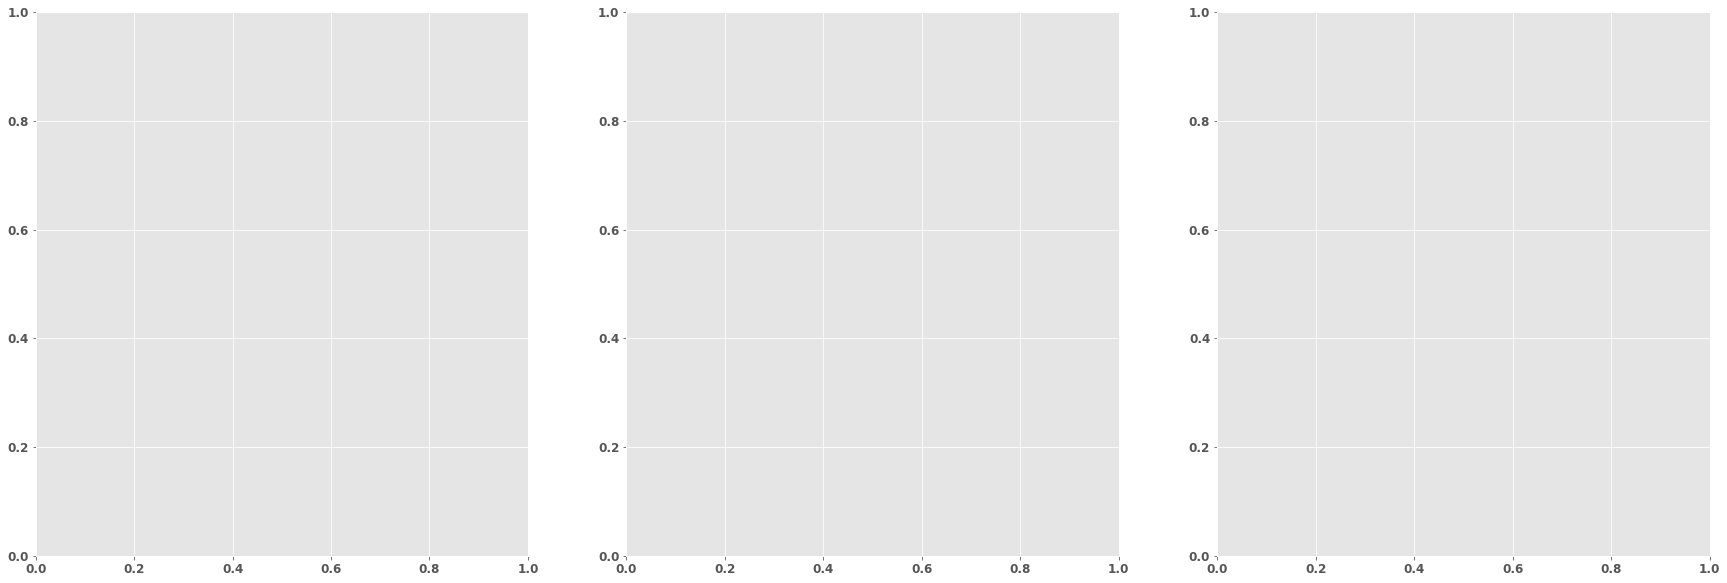

In [121]:
nov_aug_apr_hist(data_A, data_B, mask)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


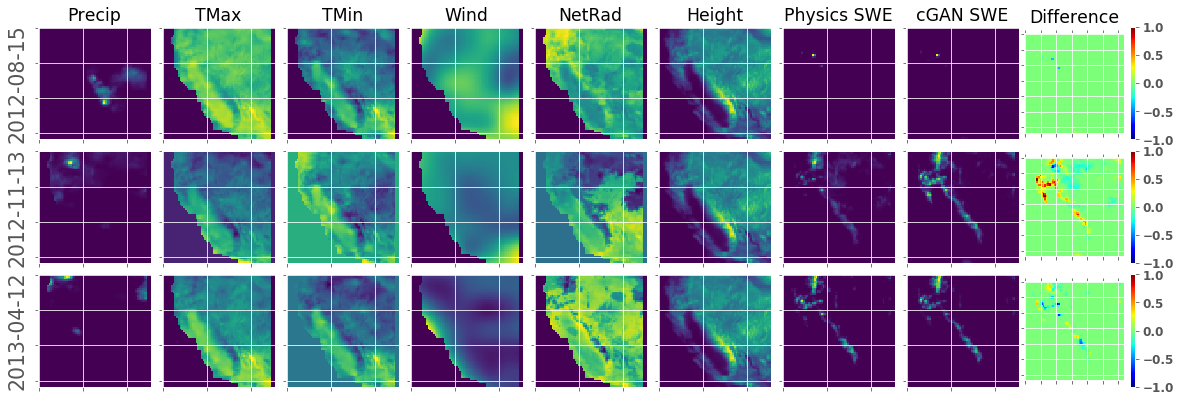

In [47]:
starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)


f = plt.figure(figsize=(20,10))
f.patch.set_facecolor('white')

gs = gridspec.GridSpec(3, 9, wspace=0, hspace=0.1, top=0.5, bottom=0.0)
plt.tight_layout()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
days = [300, 390, 540]

for row in range(0, 3):

    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 17}

    plt.rc('font', **font)
    ind = days[row]
    inp_dat = arr_to_input(data_A[ind:ind+1, :,:,:])[0,0:6]
    true_SWE = arr_to_input(data_B[ind:ind+1,:,:,:])[0,0,:,:]
    fake_SWE = model(torch.from_numpy(arr_to_input(data_A[ind:ind+1,:,:,:])).cuda()).cpu().detach().numpy()[0,0,:,:]
    temp = plt.subplot(gs[row, 0])
    temp.set_ylabel(str(starting_day + datetime.timedelta(days = int(ind))) )
    
    for col in range(0, 6):
            
        temp = plt.subplot(gs[row, col])
        temp.get_xaxis().set_ticklabels([])
        temp.get_yaxis().set_ticklabels([])
        #temp.axis('off')
        val = inp_dat[col, :, :]
        temp.imshow(np.flip(val, 0))
    
    temp = plt.subplot(gs[row, 6])
    #temp.axis('off')
    temp.get_xaxis().set_ticklabels([])
    temp.get_yaxis().set_ticklabels([])
    temp.imshow(np.flip(true_SWE, 0))
    
    temp = plt.subplot(gs[row, 7])
    #temp.axis('off')
    temp.get_xaxis().set_ticklabels([])
    temp.get_yaxis().set_ticklabels([])
    temp.imshow(np.flip(fake_SWE, 0))
    
    temp = plt.subplot(gs[row, 8])
    #temp.axis('off')
    temp.get_xaxis().set_ticklabels([])
    temp.get_yaxis().set_ticklabels([])
    temp_im = temp.matshow(np.flip(fake_SWE - true_SWE, 0), vmin=-1, vmax=1, cmap = 'jet')
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

    plt.rc('font', **font)

    plt.colorbar(temp_im, ax = temp, cmap='jet')

    


plt.rc('font', **font)


labels = ["Precip", "TMax", "TMin", "Wind", "NetRad", "Height", "Physics SWE", "cGAN SWE", "Difference"]
for col in range(0, 9):
    plt.subplot(gs[0, col]).set_title(labels[col])
    


In [113]:
sp.stats.kstest(sp.stats.gaussian_kde(inputA), sp.stats.gaussian_kde(inputB))

Power_divergenceResult(statistic=inf, pvalue=0.0)